In [2]:
import numpy as np
import pandas as pd
import random
import re
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from pylab import mpl

#做字体设置
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

movieData = pd.read_excel('doubanMovie.xlsx')
#清理不需要的字段
data1 = movieData.drop([u'页面网址',u'ID',u'IMDb链接',u'又名',u'编剧'],axis = 1)

In [42]:
#过滤掉电视剧和有缺失值的条目
notM1 = data1[u'类型'] != u'纪录片'
notM2 = data1[u'类型'] != u'真人秀'
notM3 = data1[u'类型'] != u'脱口秀'
notM = notM1 & notM2 & notM3
n = data1[u'集数'].isnull()
t = data1[u'单集片长'].notnull()
r = data1[u'豆瓣评分'].notnull()
p = data1[u'评价人数'].notnull()
d = data1[u'首播'].notnull()
data2 = data1[n & t & r & p & d & notM].drop([u'集数'],axis = 1)

#提取出上映时间和片长
#有待改进，应优先筛选出XXXX-XX-XX的格式
date_pattern = r'\d{4}\-\d{1,2}'
date_regex = re.compile(date_pattern)
time_pattern = r'\d{1,3}'
time_regex = re.compile(time_pattern)
name_pattern = r'[^x00-xff]+\d*'#r'\u4e2d\u56fd\u5927\u9646'
name_regex = re.compile(name_pattern)
date_country = pd.DataFrame(None, index = data2.index, columns = ['date','isShow'])

for i in data2.index:
    name = data2[u'名称'][i]
    date = data2[u'首播'][i]
    time = data2[u'单集片长'][i]
    new_name = name_regex.findall(name)[0]
    data2[u'名称'][i] = new_name
    new_date = date_regex.findall(date)[0]
    isShow = u'中国大陆' in date
    date_country['date'][i] = new_date
    date_country['isShow'][i] = isShow
    new_time = int(time_regex.findall(time)[0])
    data2[u'单集片长'][i] = new_time

c:\python27\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\python27\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
data3 = data2.join(date_country, how = 'outer')
data3.drop([u'首播'],axis = 1,inplace=True)

# 过滤掉首播时间不在2017年的电影    
new_date_pattern = r'\d{4}'
new_date_regex = re.compile(new_date_pattern)
for i in data3.index:
    date = data3['date'][i]
    year = int(new_date_regex.findall(date)[0])
    if year != 2017:
        data3.drop([i],axis = 0, inplace=True)
        #凡是会对原数组作出修改并返回一个新数组的，往往都有一个 inplace可选参数。
        #如果手动设定为True（默认为False），那么原数组直接就被替换。
        #也就是说，采用inplace=True之后，原数组名对应的内存值直接改变；
        #而采用inplace=False之后，原数组名对应的内存值并不改变，需要将新的结果赋给一个新的数组或者覆盖原数组的内存位置。
       # print "drop %s line" % i

In [5]:
#把电影分为在大陆上映和没上映的电影两组,每组按评价人数排名
moviesShow = data3[data3['isShow']]
moviesNotShow = data3[data3['isShow'] == False]
moviesShow.sort_values(by=[u'评价人数'],ascending = False, inplace = True)
moviesNotShow.sort_values(by=[u'评价人数'],ascending = False, inplace = True)
#拿到排名前20的电影名和
sTop20 = moviesShow[moviesShow[u'评价人数']>100000].sort_values(by=[u'豆瓣评分'],ascending = True)[-20:]
nTop10 = moviesNotShow[moviesNotShow[u'评价人数']>30000].sort_values(by=[u'豆瓣评分'],ascending = True)[-10:]
sFail10 = moviesShow[moviesShow[u'评价人数']>50000].sort_values(by=[u'豆瓣评分'],ascending = True)[:10]

c:\python27\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\python27\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [6]:
def plothist(figsize,data,bins,title,x_label,y_label):
    fig = plt.figure(figsize = (figsize[0],figsize[1]))
    ax = plt.subplot(111)
    moviesTime = [int(t) for t in data]
    rect = ax.hist(moviesTime,bins = bins,facecolor="deepskyblue",edgecolor = "white")
    print rect
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
   # for height,x in zip(rect[0],rect[1]):
   #     plt.text(x, 1.03*height, '%d' % int(height))
    #autolabel(rect)
#绘制电影评价人数分布直方图
#plothist([20,15],data3[u'评价人数'],10,u'电影评价人数分布直方图',u'人数',u'电影数量')

In [7]:
def plotbarh(figsize,y_range,data,y_ticks,x_label,title,x_lim,num_type,xoffset = 0.1,yoffset = 0.4):
    fig = plt.figure(figsize = (figsize[0],figsize[1]))
    y_pos = np.arange(y_range)
    plt.barh(y_pos,data,facecolor="deepskyblue",edgecolor="white")
    plt.yticks(y_pos,y_ticks)
    plt.xlabel(x_label)
    plt.title(title)
    plt.xlim(x_lim[0],x_lim[1])
    for x,y in zip(data,y_pos):  
        if num_type == 1:
            plt.text(x+xoffset,y-yoffset,'%0.1f' % x)
        else:
            plt.text(x+xoffset,y-yoffset,'%d' % x)

In [8]:
def plotboxplot(figsize,data,x_ticklabels,y_ticklabels,title,ylabel,xlabel):#绘制箱线图
    fig = plt.figure(figsize = (figsize[0],figsize[1]))
    ax = plt.subplot(111)
    rect = ax.boxplot(data)

    ax.set_xticklabels(x_ticklabels)
    ax.set_yticklabels(y_ticklabels)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    plt.grid(True, linestyle = "-.", color = "k", linewidth = "0.5",alpha=0.4)

In [9]:
def plotscatter(figsize,datax,datay,dataz,title,x_lable,y_label):
    fig = plt.figure(figsize=(figsize[0],figsize[1]))
    plt.scatter(datax,datay,dataz)
    plt.grid(True, linestyle = "-.", color = "r", linewidth = "0.5",alpha=0.2)
    plt.title(title)
    plt.xlabel(x_lable)
    plt.ylabel(y_label)
    plt.show()

In [10]:
def plotscatter4d(figsize,datax,datay,dataz,dataw,title,x_lable,y_label):
    fig = plt.figure(figsize=(figsize[0],figsize[1]))
    plt.scatter(datax,datay,dataz,dataw)
    plt.grid(True, linestyle = "-.", color = "k", linewidth = "0.5",alpha=0.2)
    plt.title(title)
    plt.xlabel(x_lable)
    plt.ylabel(y_label)
    plt.show()

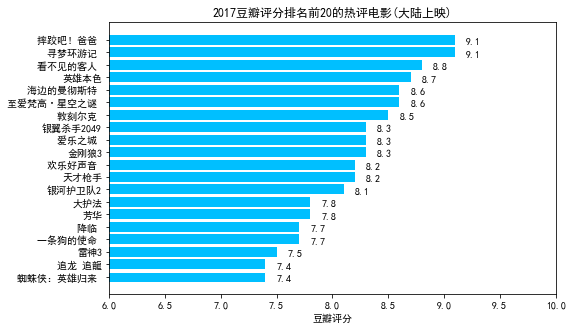

In [11]:
plotbarh([8,5],20,sTop20[u'豆瓣评分'],sTop20[u'名称'],u'豆瓣评分',u'2017豆瓣评分排名前20的热评电影(大陆上映)',[6,10],1)

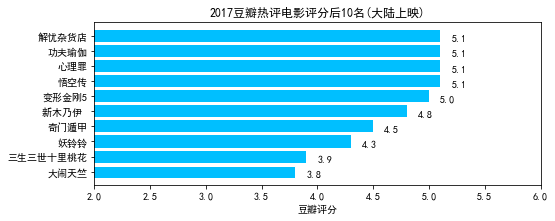

In [12]:
plotbarh([8,3],10,sFail10[u'豆瓣评分'],sFail10[u'名称'],u'豆瓣评分',u'2017豆瓣热评电影评分后10名(大陆上映)',[2,6],1)

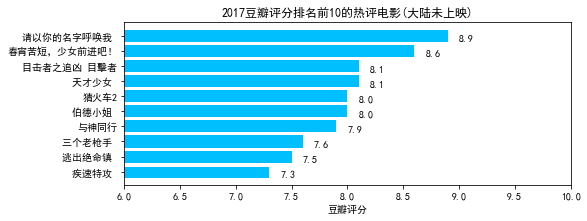

In [13]:
plotbarh([8,3],10,nTop10[u'豆瓣评分'],nTop10[u'名称'],u'豆瓣评分',u'2017豆瓣评分排名前10的热评电影(大陆未上映)',[6,10],1)

In [14]:
#地域分析
#大陆上映电影的制片地区主要有哪些国家和地区
def regions2movies(data):
    region2movie = pd.DataFrame(columns = ['region','rate','num','time','types'])
    re_pattern = r'\s\/\s'
    regex = re.compile(re_pattern)

    k = 0
    for i in data.index:
        try:
            regions = regex.split(data[u'制片地区'][i])
            for region in regions:
                region2movie.loc[k] = (region,data[u'豆瓣评分'][i],1,data[u'单集片长'][i],data[u'类型'][i])
                k = k + 1
        except:
            region2movie.loc[k] = (data[u'制片地区'][i],data[u'豆瓣评分'][i],1,data[u'单集片长'][i],data[u'类型'][i])
            k = k + 1
    return region2movie

region2movie = regions2movies(moviesShow)

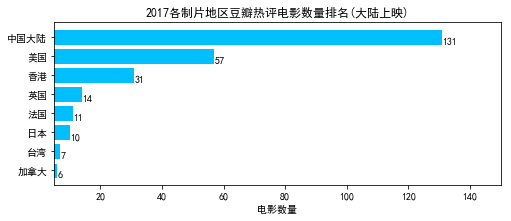

In [15]:
region_count_movies = region2movie.groupby(['region'])['num'].sum().sort_values(ascending = True)
plotbarh([8,3],8,region_count_movies[-8:],region_count_movies.index[-8:],u'电影数量',u'2017各制片地区豆瓣热评电影数量排名(大陆上映)',[5,150],0)

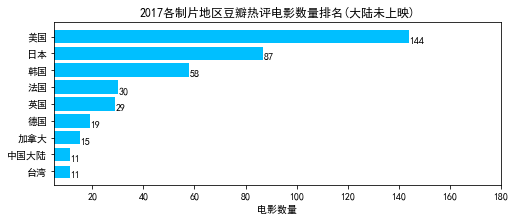

In [16]:
#未在大陆上映的电影制片地区排名（大于10的）
region2movie1 = regions2movies(moviesNotShow)
region_count_movies = region2movie1.groupby(['region'])['num'].sum().sort_values(ascending = True)
plotbarh([8,3],9,region_count_movies[-9:],region_count_movies.index[-9:],u'电影数量',u'2017各制片地区豆瓣热评电影数量排名(大陆未上映)',[5,180],0)

[ 7.3  8.3  7.7  6.7  6.3  6.8  7.3  7.2  6.5  6.   5.3  4.7  6.5  5.8  6.6
  5.8  7.8  5.4  7.5  7.6  7.5]
[ 7.1  7.3  7.7  7.8  5.2  8.1  7.1  6.7  8.   7.5  6.7  4.2  6.4  7.7  7.5
  6.9  6.   6.4  6.6  6.2  6.8]
[ 4.5  4.7  5.8  7.4  7.2  7.1  5.8  6.5  6.9  5.4  5.2  5.5  6.1  6.4  4.4
  6.2  7.3  3.8  5.   6.   8.7  7.2  5.3  5.3  7.9  4.7  3.5  4.7  4.7  5.
  5.   4.5  7.3  5.4  5.3  4.3  5.7  6.1]
[ 8.3  8.3  8.5  7.   8.9  6.7  8.2  6.6  6.8  7.7  6.7  6.9  8.4  7.3  7.4
  6.   6.4  8.1  7.5  6.6  7.5  6.4  6.8  5.3  5.8  7.7  7.9  6.5  6.7  7.5
  6.9  5.4  7.5  6.7  7.3  6.4  8.2  4.6  9.   6.6  6.9]
[ 8.6  8.6  8.3  7.   7.2  8.5  8.3  7.1  7.3  7.7  6.7  6.6  6.2  5.1  6.9
  8.   6.   5.9  8.3  6.7  7.   7.7  9.4  7.7  6.2  5.3  7.5  7.8  8.5  5.8
  7.3  8.1  6.2  7.3  6.2  5.4  6.5  7.4  9.5  7.   6.5  5.   4.3]
[ 8.8  7.3  6.6  7.8  7.2  7.3  7.7  4.   6.8  6.1  6.8  5.7  3.8  6.2  6.6
  7.2  6.5  7.5  7.3  7.4  5.5  7.6  6.9  4.8  4.7  7.1  4.3  5.7  7.9  7.2
  4.8  5.6 

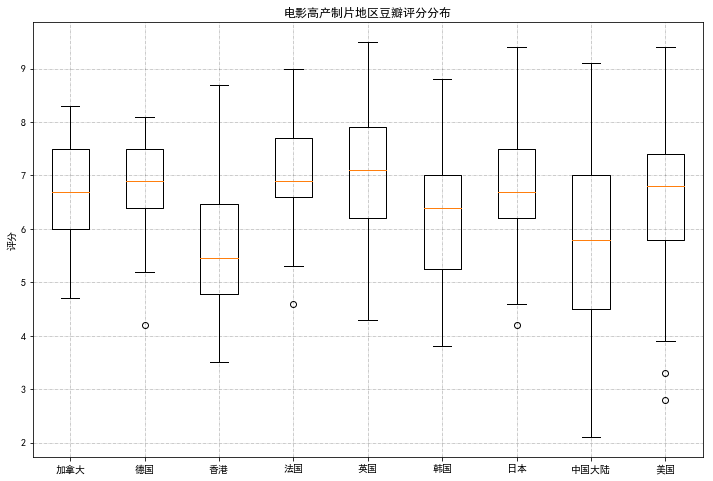

In [17]:
#这里只取电影数量在5及以上的国家进行评分上的比较
region2allmovie = regions2movies(data3)
count_rate_by_regions = region2allmovie.groupby(['region'])['rate']
region_count_allmovies = region2allmovie.groupby(['region'])['num'].sum().sort_values(ascending = True)
count_rate_by_regions.mean().sort_values(ascending = False)
df = []
for group in region_count_allmovies[region_count_allmovies > 20].index:
    v = count_rate_by_regions.get_group(group).values
    print v
    df.append(v)

plotboxplot([12,8],df,region_count_allmovies[region_count_allmovies > 20].index,range(1,10,1),u'电影高产制片地区豆瓣评分分布',u'评分','')

In [18]:
#剧情分析
def type2movies(data):
    type2rate = pd.DataFrame(columns = ['type','rate','time','num','regions'])
    re_pattern = r'\s\/\s'
    regex = re.compile(re_pattern)

    k = 0
    for i in data3.index:
        try:
            types = regex.split(data[u'类型'][i])
            for type in types:
                if (type != u'剧情') and (type != u'纪录片') and (type != u'真人秀') and (type != u'脱口秀') and (type != u'短片'):
                    type2rate.loc[k] = (type,data[u'豆瓣评分'][i],data[u'单集片长'][i],1,data[u'制片地区'][i])
                    k = k + 1
        except:
            if data[u'类型'][i] != u'纪录片' and data[u'类型'][i] != u'真人秀' and data[u'类型'][i] != u'脱口秀' and data[u'类型'][i] != u'短片':
                type2rate.loc[k] = (data[u'类型'][i],data[u'豆瓣评分'][i],data[u'单集片长'][i],1,data[u'制片地区'][i])
                k = k + 1
    return type2rate
type2rate = type2movies(data3)

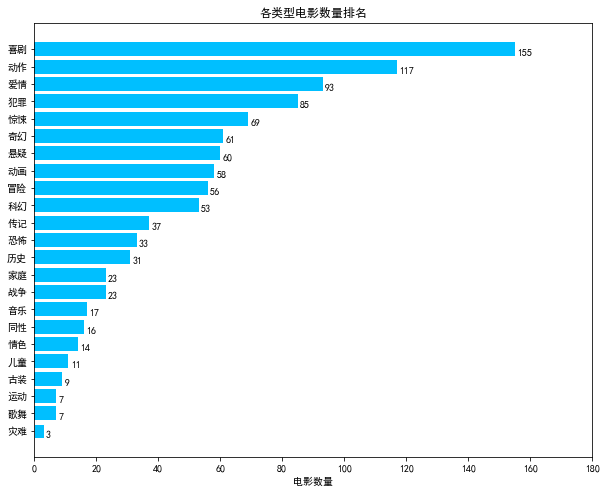

In [19]:
count_rate_by_types = type2rate.groupby(['type'])['rate']
count_by_types = count_rate_by_types.count().sort_values(ascending = True)

plotbarh([10,8],len(count_by_types)-2,count_by_types.values[2:],count_by_types.index[2:],u'电影数量',u'各类型电影数量排名',[0,180],0,0.8)

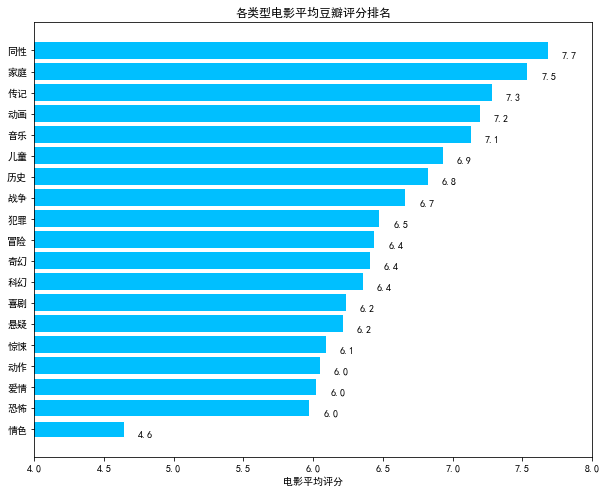

In [20]:
#各个类型的平均得分,
meanRate2type = count_rate_by_types.mean().sort_values(ascending = True)
meanRate2type2 = meanRate2type[count_by_types[count_by_types > 10].index].sort_values(ascending = True)
plotbarh([10,8],len(meanRate2type2),meanRate2type2.values,meanRate2type2.index,u'电影平均评分',u'各类型电影平均豆瓣评分排名',[4,8],1)

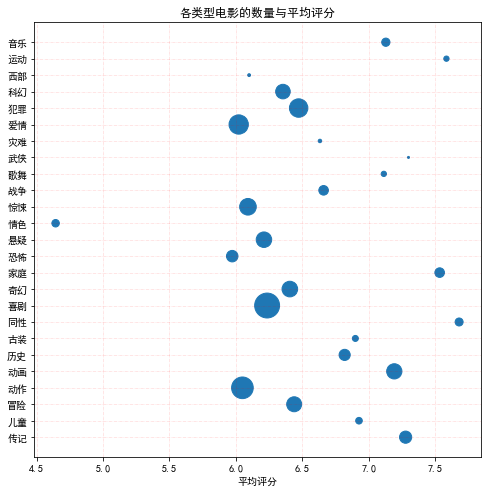

In [21]:
merge = pd.DataFrame()
merge['rate'] = meanRate2type
merge['count'] = count_by_types*10
plotscatter([8,8],merge['rate'],merge.index,merge['count']*0.4,u'各类型电影的数量与平均评分',u'平均评分','')

(array([  13.,    3.,    8.,    1.,    2.,    2.,    5.,   14.,  111.,
        132.,  104.,  118.,   47.,   22.,    6.,    3.,    2.,    0.,
          0.,    0.,    0.,    2.,    0.,    0.,    1.]), array([   1.  ,   11.36,   21.72,   32.08,   42.44,   52.8 ,   63.16,
         73.52,   83.88,   94.24,  104.6 ,  114.96,  125.32,  135.68,
        146.04,  156.4 ,  166.76,  177.12,  187.48,  197.84,  208.2 ,
        218.56,  228.92,  239.28,  249.64,  260.  ]), <a list of 25 Patch objects>)


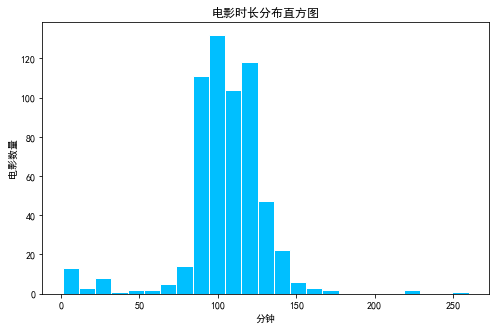

In [22]:
#分析电影时长分布
plothist([8,5],data3[u'单集片长'],25,u'电影时长分布直方图',u'分钟',u'电影数量')

c:\python27\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.
c:\python27\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


(array([  1.,   0.,   0.,   1.,   7.,  28.,  38.,  22.,   1.,   1.,   0.,
         0.,   0.,   0.,   1.]), array([  15.        ,   31.33333333,   47.66666667,   64.        ,
         80.33333333,   96.66666667,  113.        ,  129.33333333,
        145.66666667,  162.        ,  178.33333333,  194.66666667,
        211.        ,  227.33333333,  243.66666667,  260.        ]), <a list of 15 Patch objects>)


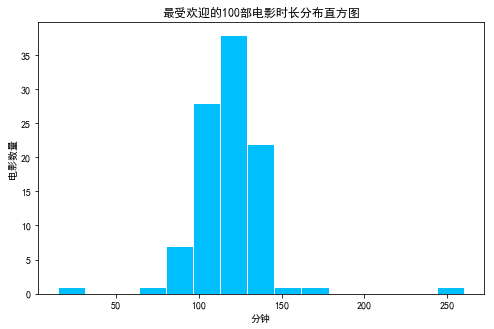

In [23]:
top100 = data3[data3[u'评价人数'] > 10000].sort_index(by = u'豆瓣评分',ascending = False)[:100]
tail100 = data3[data3[u'评价人数'] > 10000].sort_index(by = u'豆瓣评分',ascending = False)[-100:]
plothist([8,5],top100[u'单集片长'],15,u'最受欢迎的100部电影时长分布直方图',u'分钟',u'电影数量')

(array([  1.,  10.,   6.,  12.,  12.,  16.,  12.,   9.,  10.,   5.,   0.,
         3.,   3.,   0.,   1.]), array([  82.        ,   86.86666667,   91.73333333,   96.6       ,
        101.46666667,  106.33333333,  111.2       ,  116.06666667,
        120.93333333,  125.8       ,  130.66666667,  135.53333333,
        140.4       ,  145.26666667,  150.13333333,  155.        ]), <a list of 15 Patch objects>)


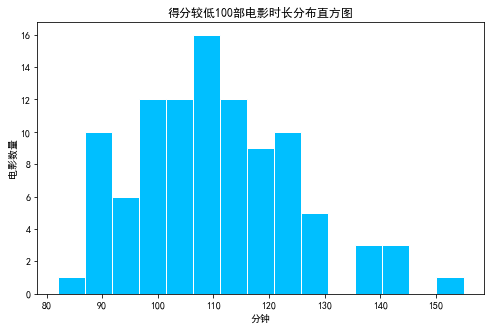

In [24]:
plothist([8,5],tail100[u'单集片长'],15,u'得分较低100部电影时长分布直方图',u'分钟',u'电影数量')

In [25]:
#哪些国家拍的电影又臭又长
region2allmovie = regions2movies(data3)
region2partmovies = region2allmovie.groupby(['region'])['num'].sum().sort_values(ascending = False)[:16]
rate2partmovies = region2allmovie.groupby(['region'])['rate'].mean()
time2partmovies = region2allmovie.groupby(['region'])['time'].sum()/(region2allmovie.groupby(['region'])['num'].sum())

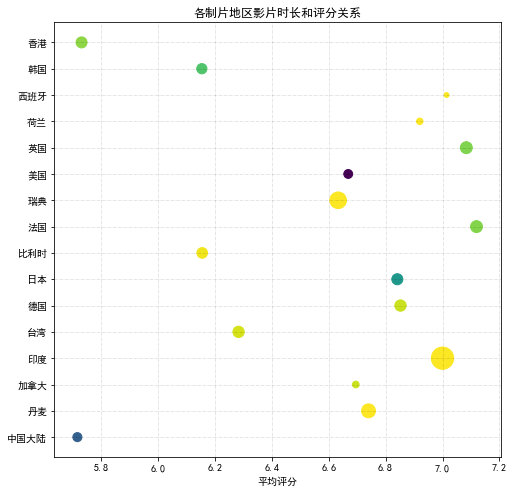

In [26]:
plotscatter4d([8,8],rate2partmovies[region2partmovies.index],region2partmovies.index
              ,(time2partmovies[region2partmovies.index]-95)*10,100 - region2partmovies*0.05
              ,u'各制片地区影片时长和评分关系',u'平均评分','')

#颜色深浅代表电影数量多少

In [27]:
#什么类型的电影更容易排出长片
type2index = type2rate.groupby(['type'])['num'].sum().sort_values(ascending = True)
type2time = (type2rate.groupby(['type'])['time'].sum()/type2rate.groupby(['type'])['num'].sum()).sort_values(ascending = True)
type2timeBT10 = type2time[type2index > 5]

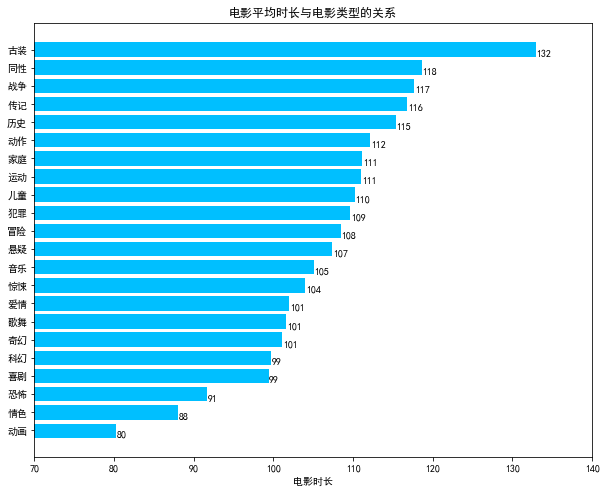

In [28]:
plotbarh([10,8],len(type2timeBT10),type2timeBT10,type2timeBT10.index,u'电影时长',u'电影平均时长与电影类型的关系',[70,140],0)

In [30]:
#制片地区的剧情偏好
region2allmovie = regions2movies(data3)
region_count_allmovies = region2allmovie.groupby(['region'])['num'].sum().sort_values(ascending = True)

re_pattern = r'\s\/\s'
regex = re.compile(re_pattern)
df0 = pd.DataFrame()

for region in region_count_allmovies[region_count_allmovies > 20].index:
    df = pd.DataFrame(columns = ['type',region])
    oneregion = region2allmovie[region2allmovie['region'] == region]
    k = 0
    for i in oneregion.index:
        try:#有多个类型标注的
            types = regex.split(oneregion['types'][i])
            for type in types:
                if type != u'剧情':
                    df.loc[k] = (type,1)
                    k = k + 1
        except:#只有一个类型标注的
            df.loc[k] = (oneregion['types'][i],1)
            k = k + 1
    dftran = df.groupby(['type'])[region].sum()
    df1 = pd.DataFrame(dftran,columns = [region])
    df0 = df1.join(df0, how = 'outer').fillna(0)#df1.join(df0)不会吧结果复制到df1里面！！！！
    
df0 = df0[df0.sum(axis=1) > 10]
f=lambda x:x.sum()   
df0 = df0/df0.apply(f).values

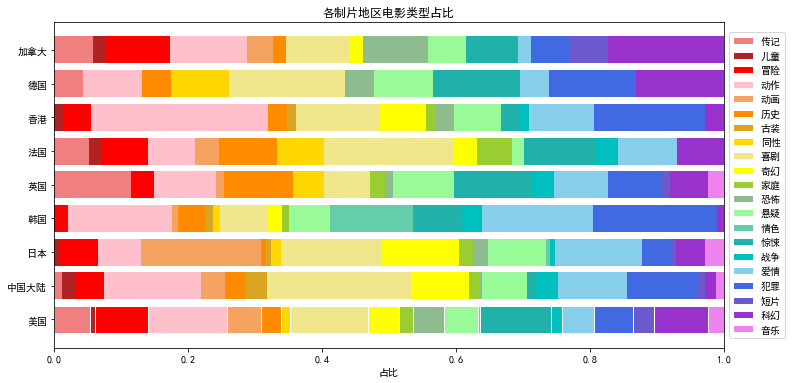

In [41]:
#绘制各国电影各类型占比情况条形图

colors=["lightcoral","firebrick","red","pink","sandybrown","darkorange","goldenrod"
        ,"gold","khaki","yellow","yellowgreen","darkseagreen","palegreen","mediumaquamarine"
        ,"lightseagreen","c","skyblue","royalblue","slateblue","darkorchid","violet"]
fig = plt.figure(figsize =(15,6))
ax = plt.subplot(111)                 
y_pos = np.arange(9) 
cal = np.zeros(9)
legendList = []
for i in np.arange(len(df0)):
    bar = ax.barh(y_pos,df0[i:i+1].values[0],left = cal,facecolor=colors[i],edgecolor="white")
    cal = cal + df0[i:i+1].values[0]
    legendList.append(bar)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
ax.legend(legendList,df0.index,loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)
plt.xlabel(u'占比')
plt.title(u'各制片地区电影类型占比')
plt.yticks(y_pos,df0.columns)
plt.xlim(0,1)
plt.show()